# 데이터 불러오기

In [2]:
import os
import shutil
import yaml
from ultralytics import YOLO


In [5]:
# 필터링된 데이터셋 저장 경로
filtered_dataset = './ppe_filtered'
new_yaml = os.path.join(filtered_dataset, 'data.yaml')

# 모델 학습

In [ ]:
model = YOLO('yolo11n.pt') # v8 사용하고 싶다면 yolov8n.pt로 작성

results = model.train(
    data=new_yaml,
    epochs=100,
    imgsz=640,
    batch=16, # 본인 gpu 성능에 맞게 수정 (작으면 정밀하지만 느리게 학습 / 크면 반대)
    workers=2, # 본인 cpu 코어 맞게 수정
    name='ppe_detection',
    patience=10, # 10번 학습할 동안 성능 개선 없으면 학습 종료
    save=True, # 모델 가중치 자동 저장 best.pt, last.pt
    plots=True # 학습 분석 가능한 다양한 그래프 생성 (loss curves 등)
)


Ultralytics 8.3.205  Python-3.11.13 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./ppe_filtered\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_detection3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspe

# 모델 성능 평가

In [ ]:
model = YOLO('runs/detect/ppe_detection/weights/best.pt') # 경로 잘 확인하기

metrics = model.val(data=new_yaml)

print(f'mAP50: {metrics.box.map50:.3f}')
print(f'mAP50-95: {metrics.box.map:.3f}')


Ultralytics 8.3.205  Python-3.11.13 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 255.283.2 MB/s, size: 37.6 KB)
val: Scanning D:\d_backup\yoomin\대학\캡스톤\sw_hybrid\PPE_yolo\ppe_filtered\valid\labels.cache... 506 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 506/506  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 7.4it/s 4.3s0.1s
                   all        506       1384      0.941      0.929      0.956      0.723
               Hardhat        354        380      0.992      0.974      0.993      0.864
          Safety_Boots        218        424      0.909      0.919      0.938      0.597
         Safety_Gloves        313        580      0.922      0.893      0.937      0.709
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 1.1ms postprocess per imag

# 테스트

In [3]:
test_img_dir = os.path.join(filtered_dataset, 'test/images')

results = model.predict(
    source=test_img_dir,
    save=True, # 결과 자동 저장
    conf=0.25, # 정확도 25% 넘으면 다 검출
    project='runs/detect', # 결과 저장할 경로
    name='test_results',
    exist_ok=False # True : 같은 이름의 폴더가 이미 존재하면 덮어쓰기 False : 같은 이름 있으면 뒷번호로 새로 만들기
)

print(f'테스트 결과 저장 위치: runs/detect/test_results')


NameError: name 'filtered_dataset' is not defined

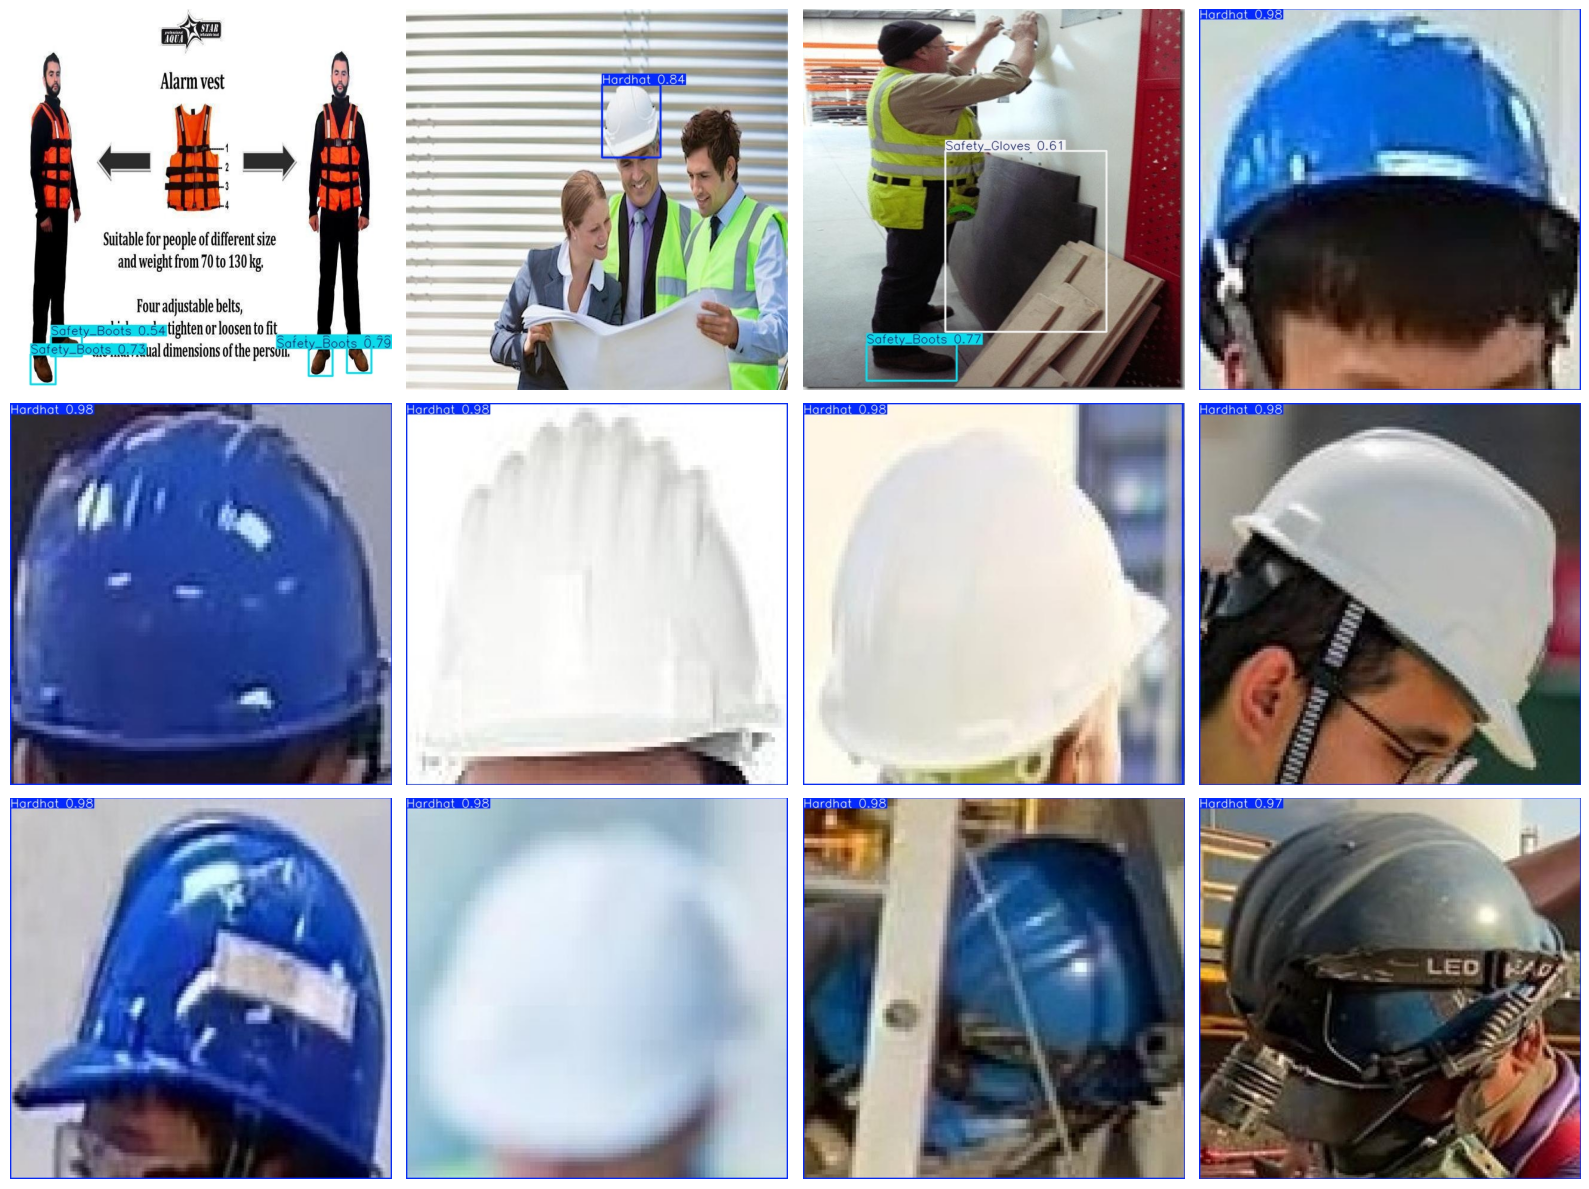

In [9]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from PIL import Image
result_img_dir = 'runs/detect/test_results'

# 테스트 이미지 불러오기
test_images = glob.glob(os.path.join(result_img_dir, '*.jpg'))[:12] # 몇 개 불러올 건지 결정

# 그리드 설정
n_cols = 4 # 행 개수 지정
n_rows = (len(test_images) + n_cols - 1) // n_cols # 열 자동 설정

# Figure 생성
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# 표시
for idx, img_path in enumerate(test_images):
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')

# 빈 칸 제거
for idx in range(len(test_images), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
